# CNN with FastText word-embeddings Testing

In [ ]:
# All training dataset
! gdown 16p0td9GgJRb9AP8i4HlX-xZGI2u849uA # new all test


! mkdir open_llm
! mv test.jsonl open_llm/

Downloading...
From: https://drive.google.com/uc?id=16p0td9GgJRb9AP8i4HlX-xZGI2u849uA
To: /content/test.jsonl
100% 39.1M/39.1M [00:00<00:00, 41.3MB/s]


In [ ]:
import os
import numpy as np
import torch
import pickle
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import json

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    gpu_capability = torch.cuda.get_device_properties(0).major, torch.cuda.get_device_properties(0).minor
    print(f"Using GPU: {gpu_name}")
    print(f"Compute Capability: {gpu_capability}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0)} bytes")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4
Compute Capability: (7, 5)
CUDA Device Count: 1
Memory Allocated: 0 bytes
Memory Reserved: 0 bytes


In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [ ]:
# Path to the folder in Google Drive where files are saved
drive_path = '/content/drive/MyDrive/Thesis/Models/CNN/'

params_save_path = os.path.join(drive_path, 'cnn_model_params.json')
with open(params_save_path, 'r') as f:
    model_params = json.load(f)

# Initialize the CNN model
cnn_model = CNN_NLP(
    vocab_size=model_params['vocab_size'],
    embed_dim=model_params['embedding_dim'],
    filter_sizes=model_params['filter_sizes'],
    num_filters=model_params['num_filters'],
    dropout=model_params['dropout']
).to(device)

model_save_path = os.path.join(drive_path, 'cnn_best_model.pth')
cnn_model.load_state_dict(torch.load(model_save_path, map_location=device))


# Load the embeddings tensor
embeddings_tensor_path = '/content/drive/MyDrive/Thesis/Models/LSTM/embeddings_tensor.pth'
embeddings_tensor = torch.load(embeddings_tensor_path)

# Load the word2idx dictionary
word2idx_path = os.path.join(drive_path, 'cnn_word2idx.pkl')
with open(word2idx_path, 'rb') as file:
    word2idx = pickle.load(file)

# Load the max_len value
max_len_path = os.path.join(drive_path, 'cnn_max_len.pkl')
with open(max_len_path, 'rb') as file:
    max_len = pickle.load(file)

# Print loaded variables to verify
print(f"Loaded embeddings tensor of shape: {embeddings_tensor.shape}")
print(f"Loaded word2idx dictionary with {len(word2idx)} entries")
print(f"Loaded max_len value: {max_len}")


<ipython-input-16-3d84e50c535b>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(model_save_path, map_location=device))
<ipython-input-

Loaded embeddings tensor of shape: torch.Size([621876, 300])
Loaded word2idx dictionary with 621876 entries
Loaded max_len value: 1793


In [ ]:
def text_process(mess):
    """
    Process text to:
    1. Remove punctuation (including all Unicode quotes)
    2. Convert text to lowercase
    3. Return cleaned text without removing stopwords
    """
    # Remove all punctuation using regex
    mess = re.sub(r"[^\w\s]", "", mess)

    # Convert the text to lowercase
    mess = mess.lower()

    # Return the cleaned text
    return mess

In [ ]:
df_test = pd.read_json("open_llm/test.jsonl", lines=True)

df_test['text'] = df_test['text'].apply(text_process)

texts_test = df_test['text'].tolist()
labels_test = df_test['label'].tolist()

In [ ]:
# Function to create input tensor
def preprocess_input(texts_test, word2idx, max_len, device):
    input_ids = []

    for text_test in texts_test:
        # Preprocess the input text (apply text_process function and tokenize)
        tokens = word_tokenize(text_test.lower())

        # Truncate tokens if they exceed max_len
        if len(tokens) > max_len:
            tokens = tokens[:max_len]

        padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

        input_id = torch.tensor(input_id, device=device).unsqueeze(dim=0)  # Unsqueeze for batch size
        input_ids.append(input_id)

    # Stack all tensors into a single tensor
    return torch.cat(input_ids, dim=0)  # Stacks tensors into a 2D tensor

# Preprocess the input data
tensor_inputs_test = preprocess_input(texts_test, word2idx, max_len, device)
tensor_labels_test = torch.tensor(labels_test, device=device)

In [ ]:
# Optimized function to test the entire dataset at once
def test_model(model, test_dataloader, device):
    """
    Test the model on the test set and calculate metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)
            logits = model(b_input_ids)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(b_labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return all_labels, all_preds, accuracy, f1, roc_auc, conf_matrix, class_report

tensor_dataset_test = TensorDataset(tensor_inputs_test, tensor_labels_test)
dataloader_test = DataLoader(tensor_dataset_test, shuffle=False, batch_size=50)

# Run testing function
all_labels, all_preds, accuracy, f1, roc_auc, conf_matrix, class_report = test_model(cnn_model, dataloader_test, device)

# Prepare the results for saving
results = {
    'accuracy': accuracy,
    'f1_score': f1,
    'roc_auc_score': roc_auc,
    'confusion_matrix': conf_matrix.tolist(),
    'classification_report': class_report
}

# Save the results to a JSON file
with open('test_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix: {conf_matrix}")
print(f"Classification Report: {json.dumps(class_report, indent=4)}")

Accuracy: 0.9016628440366973
F1 Score: 0.9037733202412681
ROC AUC Score: 0.9016628440366973
Confusion Matrix: [[6137  839]
 [ 533 6443]]
Classification Report: {
    "0": {
        "precision": 0.9200899550224888,
        "recall": 0.879730504587156,
        "f1-score": 0.8994577165469735,
        "support": 6976.0
    },
    "1": {
        "precision": 0.88478439989014,
        "recall": 0.9235951834862385,
        "f1-score": 0.9037733202412681,
        "support": 6976.0
    },
    "accuracy": 0.9016628440366973,
    "macro avg": {
        "precision": 0.9024371774563145,
        "recall": 0.9016628440366972,
        "f1-score": 0.9016155183941208,
        "support": 13952.0
    },
    "weighted avg": {
        "precision": 0.9024371774563145,
        "recall": 0.9016628440366973,
        "f1-score": 0.9016155183941208,
        "support": 13952.0
    }
}


In [ ]:
df_test['predictions'] = all_preds

df_test['correct_prediction'] = (df_test['predictions'] == df_test['label']).astype(int)

In [ ]:
# Path to your Google Drive folder
drive_path = '/content/drive/MyDrive/Thesis/Models/CNN/'

# Save the DataFrame as a CSV file
csv_save_path = os.path.join(drive_path, 'test_results_with_correct_predictions.csv')
df_test.to_csv(csv_save_path, index=False)

print(f"DataFrame saved to {csv_save_path}")

DataFrame saved to /content/drive/MyDrive/Thesis/Models/CNN/test_results_with_correct_predictions.csv


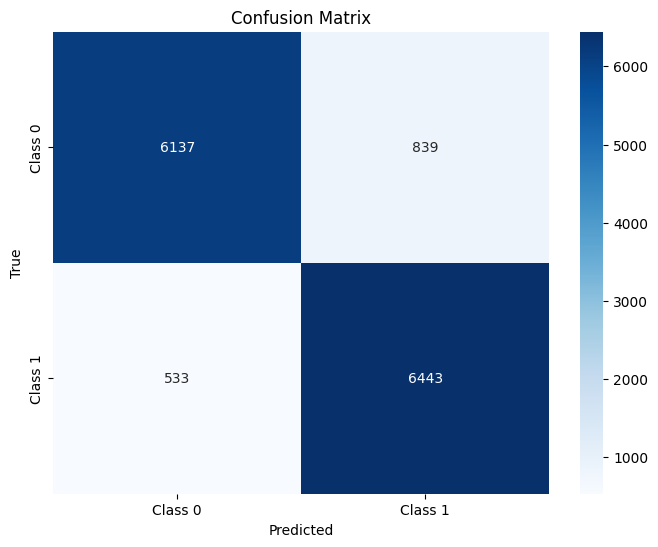

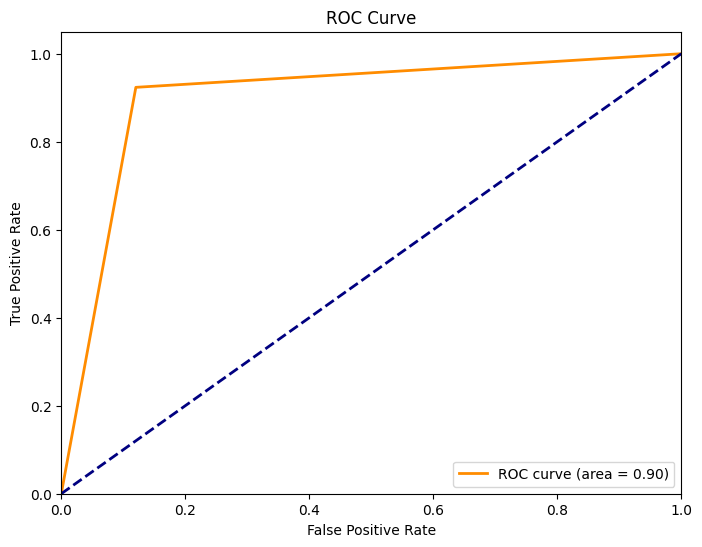

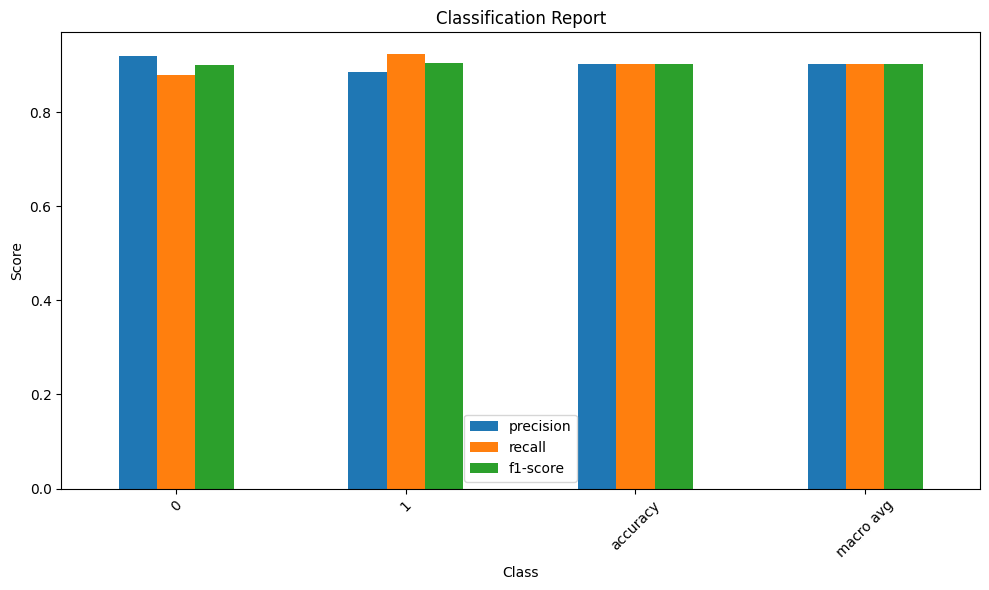

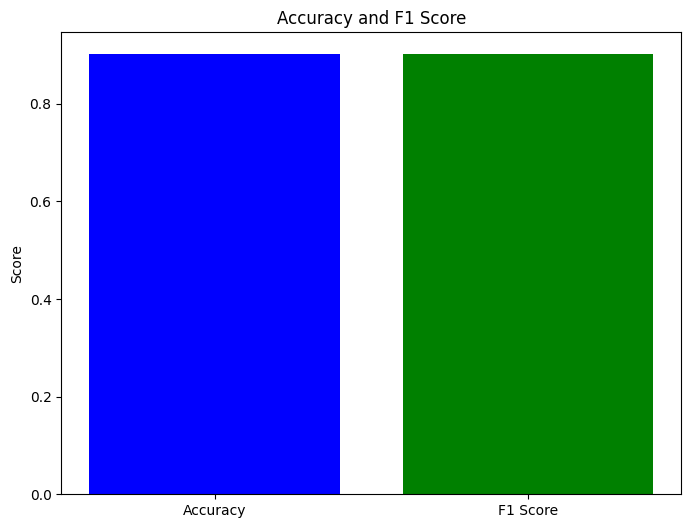

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd

# Extract the true labels and predicted labels from the DataFrame
y_true = df_test['label']
y_pred = df_test['predictions']

# 1. Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, labels, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 2. Plot ROC Curve
def plot_roc_curve(all_labels, all_preds, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# 3. Plot Classification Report
def plot_classification_report(class_report, title="Classification Report"):
    report_df = pd.DataFrame(class_report).transpose()
    report_df = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy' row
    report_df.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Plot Accuracy and F1 Score for each class
def plot_accuracy_f1(accuracy, f1, title="Accuracy and F1 Score"):
    plt.figure(figsize=(8, 6))
    labels = ['Accuracy', 'F1 Score']
    values = [accuracy, f1]
    plt.bar(labels, values, color=['blue', 'green'])
    plt.title(title)
    plt.ylabel('Score')
    plt.show()

# Running the plotting functions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, labels=['Class 0', 'Class 1'])

# ROC Curve
plot_roc_curve(y_true, y_pred)

# Classification Report (Precision, Recall, F1)
class_report = classification_report(y_true, y_pred, output_dict=True)
plot_classification_report(class_report)

# Accuracy and F1 Score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
plot_accuracy_f1(accuracy, f1)
